# Carregamento das bases

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

raw_target_dataset = pd.read_csv('/mnt/data/target_apartments1_wn.csv')
raw_target_dataset[['latitude', 'longitude']] = raw_target_dataset[['latitude', 'longitude']].astype(float)
raw_target_dataset.drop(columns=['point', 'neighborhood'], inplace=True)
#dummies = pd.get_dummies(raw_target_dataset['neighborhood'])
#raw_target_dataset = pd.concat([raw_target_dataset, dummies], axis=1).drop(columns='neighborhood')

raw_simulated_dataset = pd.read_csv('/mnt/data/simulated_listings1_wn.csv')
raw_simulated_dataset[['latitude', 'longitude']] = raw_simulated_dataset[['latitude', 'longitude']].astype(float)
raw_simulated_dataset.drop(columns=['point', 'neighborhood'], inplace=True)
#dummies = pd.get_dummies(raw_simulated_dataset['neighborhood'])
#raw_simulated_dataset = pd.concat([raw_simulated_dataset, dummies], axis=1).drop(columns='neighborhood')

# Questão 1

## Modelo de estimativa de preço

Começaremos pelo modelo de preço. Primeiro separamos a base de treino e teste.

O modelo é necessário para estimar o valor de venda do apartamento, seja ele com ou sem reforma necessária. Para isso não foi considerada a variável time_on_market por se tratar de uma variável que não necessariamente temos para apartamentos que vamos comprar.

In [2]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RepeatedKFold, cross_validate
X = raw_simulated_dataset.drop(['value', 'sold', 'time_on_market'], axis=1)
X_price = X
y = raw_simulated_dataset['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

O modelo escolhido foi XGboost como um ponto de partida para responder a solução.

In [3]:
from sklearn.metrics import mean_squared_error
from numpy import absolute
import xgboost as xgb

In [4]:
model=xgb.XGBRegressor(learning_rate = 0.01,
                           n_estimators  = 500,
                           max_depth     = 5,
                           eval_metric='rmsle')

Foi escolhido como métrica mean squared logarithmic error porque essa métrica é recomendada quando os targets possuem crescimento exponencial, como por exemplo preço dos apartamentos.
Essa escolha é feita é para não penalizar grandes diferenças entre a predição e o valor real.

In [5]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=8)

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1)
print('Mean RMSLE: %.3f (%.3f)' % (absolute(scores.mean()), scores.std()))

Mean RMSLE: 0.038 (0.002)


In [7]:
score = cross_validate(model, X, y, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1, return_estimator=True)
test_score_abs = absolute(score['test_score'])
best_model_idx = np.where(test_score_abs == test_score_abs.min())
model_best = score['estimator'][best_model_idx[0][0]]
price_model = model_best

In [8]:
import pickle
file_name = "/mnt/data/xgb_price_regressor.pkl"

# save
#pickle.dump(model_best, open(file_name, "wb"))

In [9]:
preds = model_best.predict(X_test)
df_preds = pd.DataFrame(y_test)
df_preds['preds'] = preds

df_preds

,value,preds
6446,544249,6.171596e+05
6393,627876,6.203285e+05
4924,2054370,2.281459e+06
6480,1004540,1.201509e+06
4455,1326930,9.538582e+05
...,...,...
885,1365730,1.701445e+06
3042,908762,9.127916e+05
530,487133,6.860983e+05
7752,3097650,3.029174e+06


In [14]:
def relative_error(model, X, y):
    preds = model.predict(X)
    df_preds = pd.DataFrame()
    df_preds['target'] = y 
    df_preds['preds'] = preds
    df_preds['relative_error'] = abs((df_preds['target'] - df_preds['preds'])/df_preds['target'])
    df_preds['latitude'] = X['latitude'] 
    df_preds['longitude'] = X['longitude']
    
    return df_preds

In [15]:
rel_error_df = relative_error(model_best, X, y)


In [16]:
from keplergl import KeplerGl
map_1 = KeplerGl(height=800)
map_1.add_data(data=rel_error_df)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

Por este mapa podemos entender melhor para que quadrantes/localidades o modelo está com o erro relativo menor ou maior com relação também ao valor médio dos apartamentos no dataset dessa área, além da representatividade no dataset. 

Podemos ter uma noção de localidades que devemos enriquecer os dados com mais apartamentos transicionados em outras fontes de dados ou até melhorar as features com relação a áreas para capturar melhor as diferenças de um local a outro. Por ex.: renda per capta.

Essas features ajudam na generalização do modelo para datasets diferentes do que estamos trabalhando atualmente.

In [17]:
map_1.save_to_html(file_name='/mnt/data/relative_error_map.html')

Map saved to /mnt/data/relative_error_map.html!


## avaliar resultados do modelo com mais métricas?

## Modelo de estimativa de tempo até a venda

Aqui me baseei em alguns artigos no blog da loft sobre análise de sobrevivência como saída para não construir um modelo enviesado somente com os casos em que já houve o evento de venda do apartamento. A função objetivo apropriada para sobrevivência escolhida foi a aft. 
O modelo cox,  por ser um modelo semi-paramétrico, conseguimos treinar modelos sem saber ou assumir a distribuição dos dados do problema escolhido. A outra possibilidade seria o uso do modelo AFT que seria um modelo paramétrico que é muito sensível a destribuição dos dados, porém diferentemente da cox este modelo retorna o valor do tempo até o evento, diferentemente do cox que retorna o risco relativo.

O AFT utiliza valores de evento com intervalos de tempo, no caso de eventos que ocorreram [T, T] , no caso de censurados [T, inf]

In [116]:
raw_simulated_dataset_cox = raw_simulated_dataset.copy()
mask = (raw_simulated_dataset['sold']==1)
raw_simulated_dataset_cox['sold'] = mask
X = raw_simulated_dataset_cox.drop(['time_on_market'], axis=1)
X_liquidity = X.drop(['sold'], axis=1)
y = raw_simulated_dataset_cox['time_on_market']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [108]:
xgb_train = xgb.DMatrix(X_train.drop(['sold'], axis=1))
xgb_test = xgb.DMatrix(X_test.drop(['sold'], axis=1))
xgb_eval = xgb.DMatrix(X_eval.drop(['sold'], axis=1))


y_lower_bound = y_train
y_upper_bound = np.where(X_train['sold'], y_train, np.inf)
xgb_train.set_float_info("label_lower_bound", y_lower_bound.copy())
xgb_train.set_float_info("label_upper_bound", y_upper_bound.copy())

y_lower_bound = y_test
y_upper_bound = np.where(X_test['sold'], y_test, np.inf)
xgb_test.set_float_info("label_lower_bound", y_lower_bound.copy())
xgb_test.set_float_info("label_upper_bound", y_upper_bound.copy())

y_lower_bound = y_eval
y_upper_bound = np.where(X_eval['sold'], y_eval, np.inf)
xgb_eval.set_float_info("label_lower_bound", y_lower_bound.copy())
xgb_eval.set_float_info("label_upper_bound", y_upper_bound.copy())

In [128]:
params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 0.005, 
    'max_depth': 8, 
    'booster':'gbtree',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

liquidity_model = xgb.train(params, xgb_train, num_boost_round=1200, evals=[(xgb_eval, 'eval')], early_stopping_rounds=10, verbose_eval=100)

[0]	eval-aft-nloglik:25.95282
[100]	eval-aft-nloglik:25.03333
[200]	eval-aft-nloglik:23.67600
[300]	eval-aft-nloglik:21.89251
[400]	eval-aft-nloglik:19.41668
[500]	eval-aft-nloglik:16.32497
[600]	eval-aft-nloglik:12.52965
[700]	eval-aft-nloglik:8.62403
[800]	eval-aft-nloglik:6.09822
[900]	eval-aft-nloglik:4.63161
[1000]	eval-aft-nloglik:3.79465
[1100]	eval-aft-nloglik:3.32699
[1199]	eval-aft-nloglik:3.07361


In [129]:
import lifelines
y_pred = liquidity_model.predict(xgb_test)
c_index = lifelines.utils.concordance_index(y_test, y_pred)
print(f"C-index: {c_index:.3f}")
print(f"Average survival time: {y_pred.mean():.0f} days")

C-index: 0.484
Average survival time: 109 days


O c-index é uma métrica que avalia a acurácia do ranking da predição do tempo. É uma generalização da AUC, area under the curve, baeseada na área abaixo da curva ROC em que taxas true positive é plotada contra as taxas de falso positivos. 
No caso do c-index temos:
- 0.5 é um resultado randômico
- 1.0 é uma concordância perfeita
- 0.0 é uma perfeita anti-concodância 

In [115]:
import pickle
file_name = "/mnt/data/xgb_liquidity_survival_aft.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
#xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [117]:
import shap
shap_values = shap.TreeExplainer(liquidity_model).shap_values(X_liquidity)

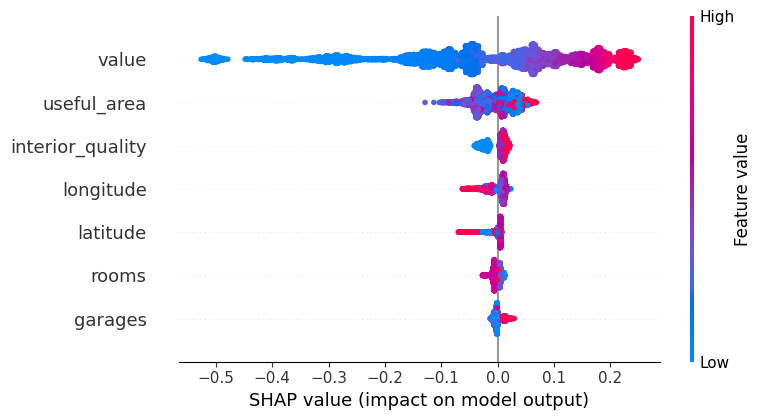

In [119]:
shap.summary_plot(shap_values, X_liquidity)

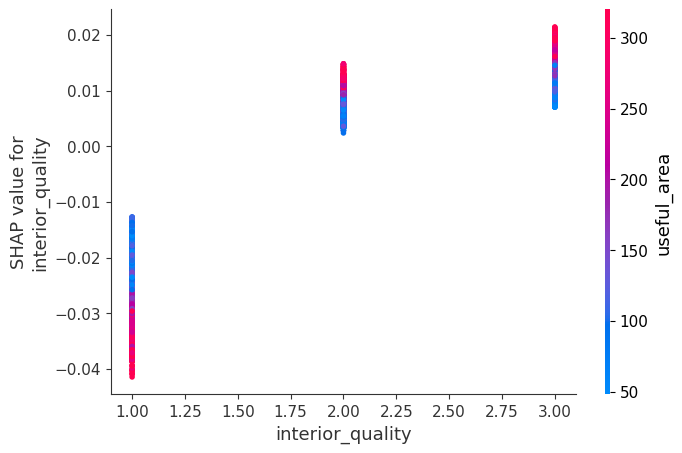

In [122]:
shap.dependence_plot("interior_quality", shap_values, X_liquidity)

In [123]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_liquidity.iloc[0,:])

# Questão 2

In [30]:
# load
#file_name = "/mnt/data/xgb_price_regressor.pkl"
#price_model = pickle.load(open(file_name, "rb"))

In [31]:
# load
#file_name = "/mnt/data/xgb_liquidity_survival_cox.pkl"
#liquidity_model = pickle.load(open(file_name, "rb"))

Diretrizes:
- Pagamos exatamente o valor pedido pelo proprietário (coluna value na base
target_apartments.csv ).
- A reforma traz o apartamento para o melhor estado de conservação possível
( interior_quality=3 ).
- O capital disponível para compra dos apartamentos é de R$ 150 milhões.

In [130]:
raw_target_df_iq = raw_target_dataset.copy()
raw_target_df_iq['interior_quality']=3

In [131]:
X= raw_target_df_iq.drop(['value'], axis=1)
sell_value_preds = price_model.predict(X)

In [132]:
raw_target_df_iq = raw_target_df_iq.rename(columns={'value': 'buy_value'})
raw_target_df_iq['value']=sell_value_preds

## Prever Liquidity (time_on_market) com o sell_value

In [133]:
X = raw_target_df_iq.drop(['buy_value'], axis=1)
X.columns =  ['rooms', 'garages', 'useful_area', 'latitude', 'longitude', 'value', 'interior_quality'] 
X_dmatrix = xgb.DMatrix(X)
time_on_market_pred = liquidity_model.predict(X_dmatrix)
raw_target_df_iq['time_on_market'] = time_on_market_pred

## Rankear e selecionar apartamentos até valor de 150mi

In [134]:
rank_df = raw_target_df_iq[['buy_value', 'value', 'time_on_market']]
rank_df['money_per_time'] = (rank_df['value'] - rank_df['buy_value'])/ rank_df['time_on_market']
rank_df_ordered = rank_df.sort_values(by=['money_per_time'], ascending=False)
rank_df_ordered['cum_sum'] = rank_df_ordered['value'].cumsum()
best_apts_df = rank_df_ordered[rank_df_ordered['cum_sum']<150000000]
best_apts_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,buy_value,value,time_on_market,money_per_time,cum_sum
3494,1235190,3052390.00,53.430813,34010.337922,3052390.0
561,2536710,4498312.00,59.528793,32952.154581,7550702.0
6515,1839720,3517526.00,62.062378,27034.188118,11068228.0
3593,1653800,3185316.75,57.903362,26449.530560,14253545.0
1925,1786500,3265745.75,56.472450,26194.113117,17519290.0
2324,1561710,2977790.00,55.200394,25653.440233,20497080.0
2375,2341220,3764195.00,55.959682,25428.575312,24261276.0
5450,2369380,3736447.50,55.509113,24627.802868,27997724.0
4656,1429770,2649213.25,49.703659,24534.275205,30646938.0
6781,1875720,3282029.50,58.857487,23893.468414,33928968.0


# Questão 3

In [44]:
shap.initjs()

In [37]:
shap_values = shap.TreeExplainer(liquidity_model).shap_values(X_liquidity)

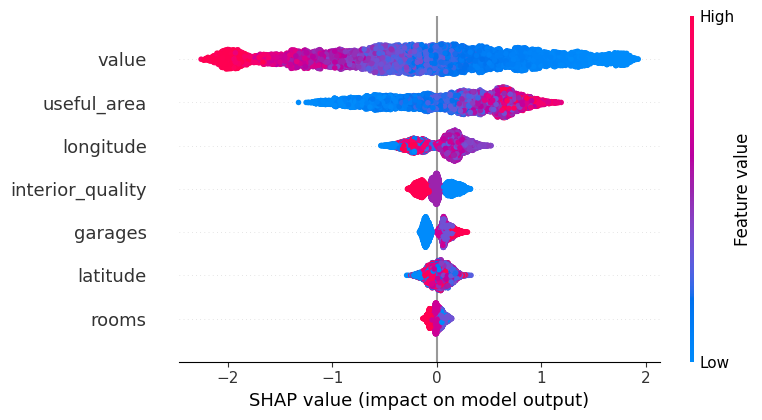

In [38]:
shap.summary_plot(shap_values, X_liquidity)

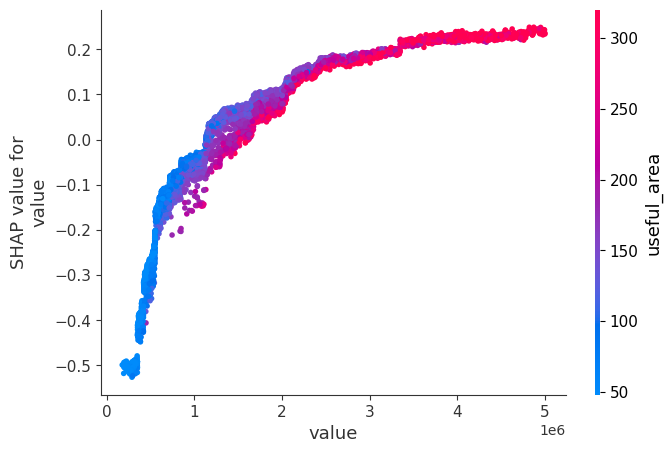

In [148]:
shap.dependence_plot("value", shap_values, X_liquidity)

<AxesSubplot:xlabel='time_on_market', ylabel='Count'>

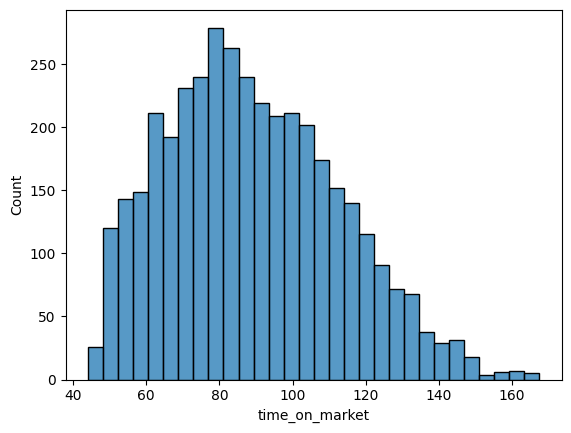

In [137]:
raw_simul_dataset_10off = raw_simulated_dataset.copy()[raw_simulated_dataset['sold'] ==1]
raw_simul_dataset_10off['value'] = raw_simul_dataset_10off['value']*0.9
X_10off = raw_simul_dataset_10off.drop(['time_on_market', 'sold'], axis=1)
X_10off.columns =  ['rooms', 'garages', 'useful_area', 'latitude', 'longitude', 'value', 'interior_quality'] 
X_10off_dm = xgb.DMatrix(X_10off)
time_on_market_pred = liquidity_model.predict(X_10off_dm)
raw_simul_dataset_10off['time_on_market'] = time_on_market_pred
sns.histplot(data=raw_simul_dataset_10off, x="time_on_market", bins=30)

<AxesSubplot:xlabel='time_on_market', ylabel='Count'>

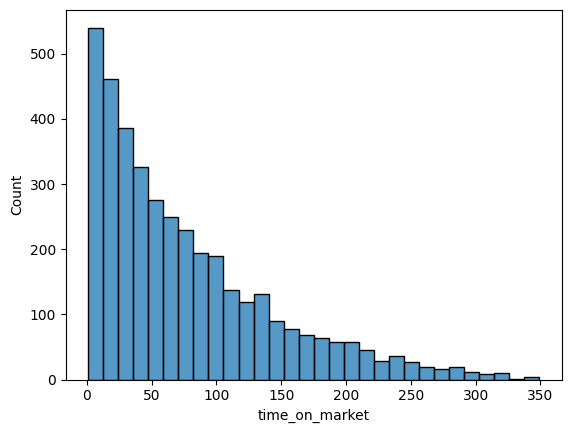

In [138]:
sns.histplot(data=raw_simulated_dataset[raw_simulated_dataset['sold'] ==1], x="time_on_market", bins=30)

<AxesSubplot:xlabel='time_on_market', ylabel='Count'>

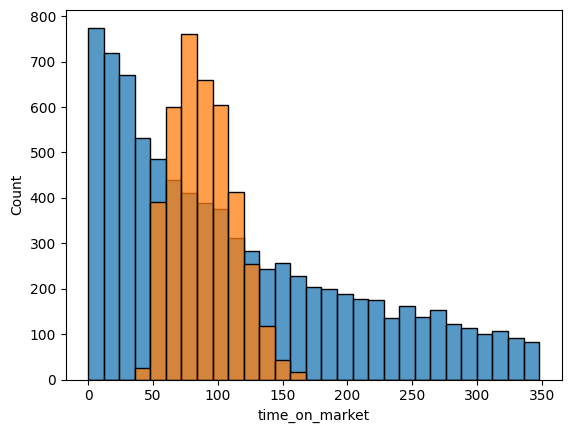

In [147]:
import matplotlib.pyplot as plt

plot_df = pd.DataFrame()
plot_df['time_on_market'] = raw_simulated_dataset['time_on_market']
plot_df['time_on_market_10off'] = raw_simul_dataset_10off['time_on_market']
fig, ax = plt.subplots()
sns.histplot(plot_df['time_on_market'], bins=range(0, 350, 12), ax=ax, kde=False)
sns.histplot(plot_df['time_on_market_10off'], bins=range(0, 350, 12), ax=ax, kde=False)

<AxesSubplot:xlabel='time_on_market_diff', ylabel='Count'>

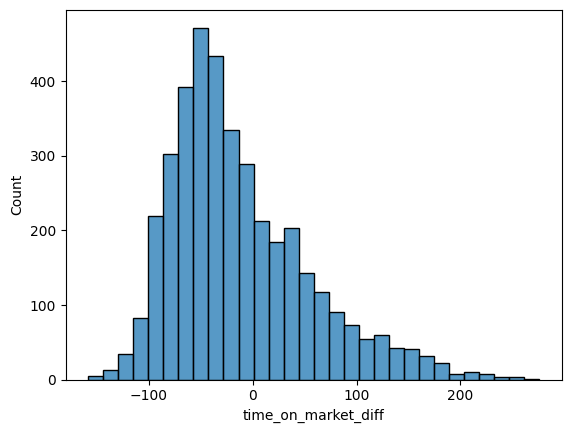

In [140]:
raw_simul_dataset_10off['time_on_market_diff'] = raw_simulated_dataset['time_on_market']  - raw_simul_dataset_10off['time_on_market'] 
sns.histplot(data=raw_simul_dataset_10off, x="time_on_market_diff", bins=30)

In [141]:
raw_simul_dataset_10off['time_on_market_diff'].mean() 

-12.438862963348742

# Questão 4

## Price

In [45]:
X_price_sample = X_price.sample(500, random_state=10)

In [46]:
explainer = shap.TreeExplainer(price_model)
shap_values = explainer.shap_values(X_price)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [47]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_price.iloc[0,:])

O gráfico acima serve para demonstrar a contribuição no modelo para aumentar ou diminuir um valor. O azul significa uma diminuição no valor do apartamento para o modelo.

In [48]:
#shap.force_plot(explainer.expected_value, shap_values, X_price.sample())

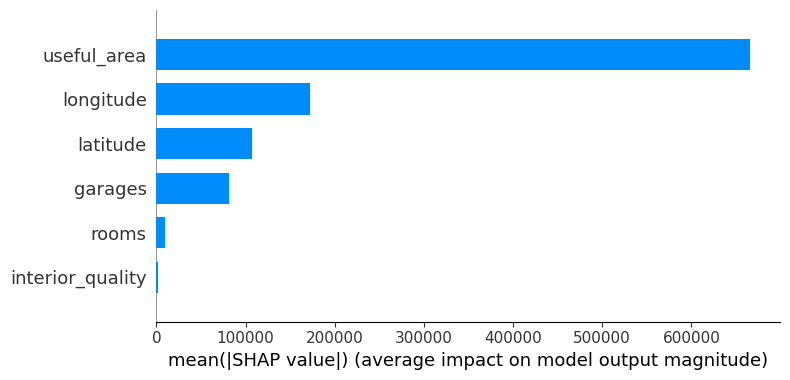

In [51]:
shap.summary_plot(shap_values, X_price, plot_type='bar')

## Liquidity

In [149]:
X_liquidity_sample = X_liquidity.sample(500, random_state=10)

In [152]:
explainer_liquidity = shap.TreeExplainer(liquidity_model)
shap_values_liquidity = explainer_liquidity.shap_values(X_liquidity)

In [153]:
shap.force_plot(explainer_liquidity.expected_value, shap_values_liquidity[0,:], X_liquidity.iloc[0,:])

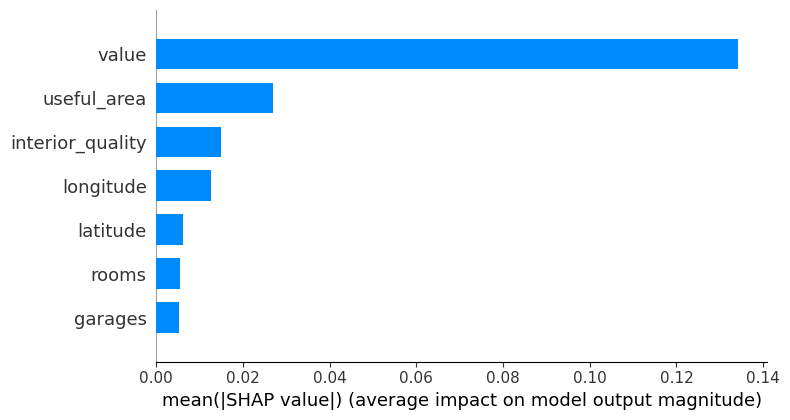

In [154]:
shap.summary_plot(shap_values, X_liquidity, plot_type='bar')